This code applies the analysis from https://arxiv.org/abs/2002.07572 to the daily updated data provided by JHU CSSE https://systems.jhu.edu/research/public-health/ncov/

The SIRX code comes from https://github.com/benmaier/COVID19CaseNumberModel

In [1]:
import csv
from datetime import datetime
from SIRX import SIRXConfirmedModel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
data = {}
dates = []

with open('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv', 'r') as datafile:
    reader = csv.reader(datafile)

    first_row = next(reader)
    
    dates = [ datetime.strptime(d, '%m/%d/%y').date() for d in first_row[4:] ]
    
    for row in reader:
        country1 = row[1]
        country2 = row[0]

        if country2 != "":
            country = country1 + "-" + country2
        else:
            country = country1
            
        data[country] = [ int(e) for e in row[4:] ]
        #print(country)

In [3]:
model = SIRXConfirmedModel()

In [11]:
population = {  
                'Netherlands' : 17180000, 
                'Italy' :       60480000,
                'Germany' :     82790000,
                'Spain' :       46660000,
                'United Kingdom-UK' : 66440000,
                'France-France' : 66990000,
                'Korea, South' : 51470000,
                'Iran' : 81160000,
                'Portugal' :     10290000,
                'Greece' : 10740000,
                'Norway' : 5368000,
                'Switzerland' : 8570000,
                'Sweden' : 10120000,
                'Austria' : 8822000,
                'Belgium' : 11400000,
                'Poland' : 37980000
             }

Netherlands
Population size 17180000
start on  2020-02-27
[1, 1, 6, 10, 18, 24, 38, 82, 128, 188, 265, 321, 382, 503, 503]


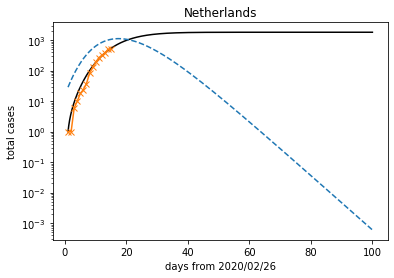

**************************************************
Italy
Population size 60480000
start on  2020-01-31
[2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 20, 62, 155, 229, 322, 453, 655, 888, 1128, 1694, 2036, 2502, 3089, 3858, 4636, 5883, 7375, 9172, 10149, 12462, 12462]


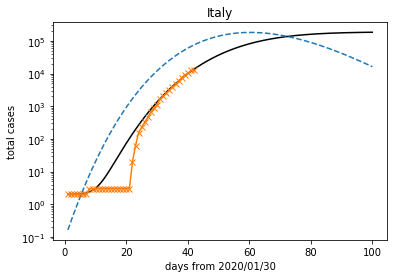

**************************************************
Germany
Population size 82790000
start on  2020-01-27
[1, 4, 4, 4, 5, 8, 10, 12, 12, 12, 12, 13, 13, 14, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 27, 46, 48, 79, 130, 159, 196, 262, 482, 670, 799, 1040, 1176, 1457, 1908, 2078]


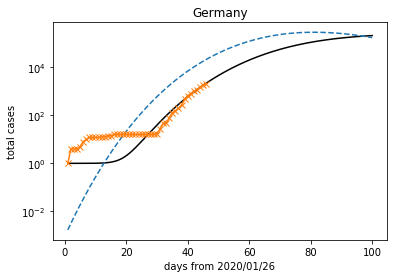

**************************************************
Spain
Population size 46660000
start on  2020-02-01
[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 13, 15, 32, 45, 84, 120, 165, 222, 259, 400, 500, 673, 1073, 1695, 2277, 2277]


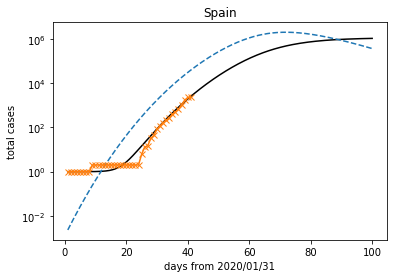

**************************************************
United Kingdom-UK
Population size 66440000
start on  2020-01-31
[2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 13, 13, 13, 15, 20, 23, 36, 40, 51, 85, 115, 163, 206, 273, 321, 382, 456, 456]


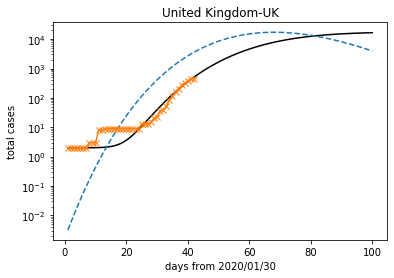

**************************************************
France-France
Population size 66990000
start on  2020-02-03
[6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 14, 18, 38, 57, 100, 130, 191, 204, 285, 377, 653, 949, 1126, 1209, 1784, 2281, 2281]


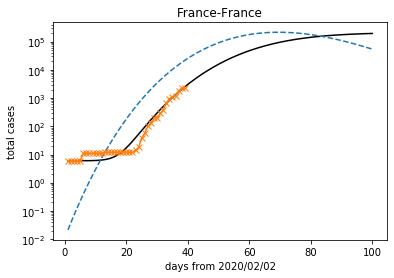

**************************************************
Korea, South
Population size 51470000
start on  2020-01-25
[2, 3, 4, 4, 4, 4, 11, 12, 15, 15, 16, 19, 23, 24, 24, 25, 27, 28, 28, 28, 28, 28, 29, 30, 31, 31, 104, 204, 433, 602, 833, 977, 1261, 1766, 2337, 3150, 3736, 4335, 5186, 5621, 6088, 6593, 7041, 7314, 7478, 7513, 7755, 7869]


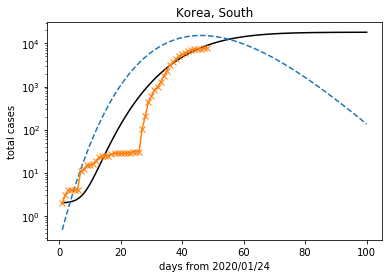

**************************************************
Iran
Population size 81160000
start on  2020-02-19
[2, 5, 18, 28, 43, 61, 95, 139, 245, 388, 593, 978, 1501, 2336, 2922, 3513, 4747, 5823, 6566, 7161, 8042, 9000, 10075]


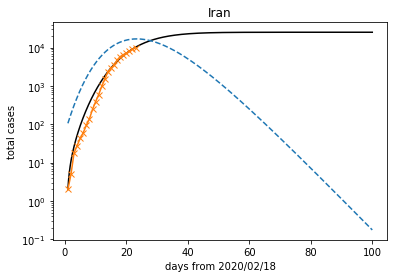

**************************************************
Portugal
Population size 10290000
start on  2020-03-02
[2, 2, 5, 8, 13, 20, 30, 30, 41, 59, 59]


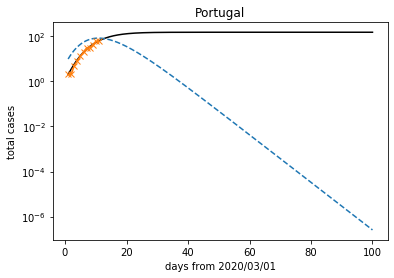

**************************************************
Greece
Population size 10740000
start on  2020-02-26
[1, 3, 4, 4, 7, 7, 7, 9, 31, 45, 46, 73, 73, 89, 99, 99]


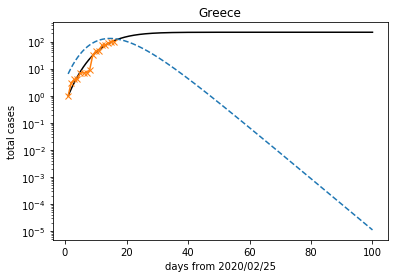

**************************************************
Norway
Population size 5368000
start on  2020-02-26
[1, 1, 6, 15, 19, 25, 32, 56, 87, 108, 147, 176, 205, 400, 598, 702]


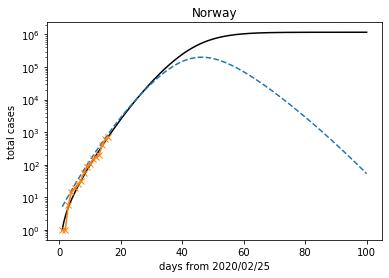

**************************************************
Switzerland
Population size 8570000
start on  2020-02-25
[1, 1, 8, 8, 18, 27, 42, 56, 90, 114, 214, 268, 337, 374, 491, 652, 652]


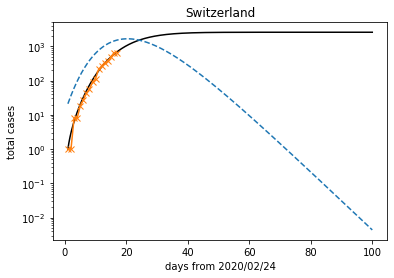

**************************************************
Sweden
Population size 10120000
start on  2020-01-31
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 7, 7, 12, 14, 15, 21, 35, 94, 101, 161, 203, 248, 355, 500, 599]


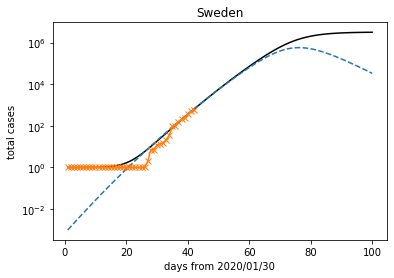

**************************************************
Austria
Population size 8822000
start on  2020-02-25
[2, 2, 3, 3, 9, 14, 18, 21, 29, 41, 55, 79, 104, 131, 182, 246, 302]


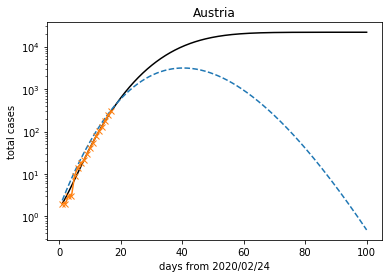

**************************************************
Belgium
Population size 11400000
start on  2020-02-04
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 8, 13, 23, 50, 109, 169, 200, 239, 267, 314, 314]


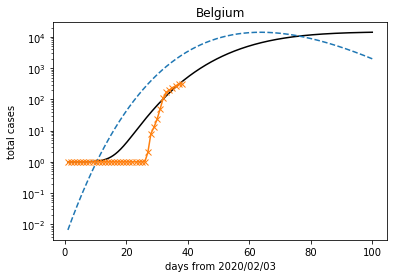

**************************************************
Poland
Population size 37980000
start on  2020-03-04
[1, 1, 5, 5, 11, 16, 22, 31, 49]


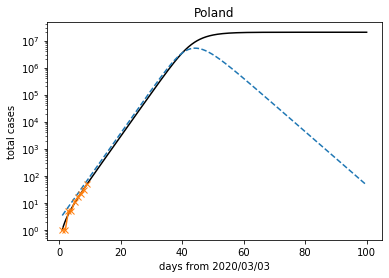

**************************************************


In [12]:
for country, pop in population.items():
    print(country)
    print("Population size", pop)

    t0 = next( i for i,d in enumerate( data[country] ) if d > 0 )
    
    if country == 'France-France':
        t0 += 10
        # atypical start of the pandemic in France
        
    if country == 'Korea, South':
        t0 += 3
        # atypical start of the pandemic in France
        
    cases = data[country][t0:]
    pop = population[country]
    
        
    print("start on ", dates[t0])
    t = [ (d - dates[t0-1]).total_seconds() / 24 / 3600 for d in dates[t0:] ]
    

    out = model.fit(t,cases,maxfev=1000,N=pop)
    params = out.params
    
    #print(params)
    
    print(cases)
    
    N = params['N']
    tt = np.logspace(np.log(t[0]), np.log(100), 1000,base=np.exp(1))

    result = model.SIRX(tt, cases[0], 
                        params['eta'],
                        params['rho'],
                        params['kappa'],
                        params['kappa0'],
                        N,
                        params['I0_factor'],
                        )
    X = result[2,:]*N
    I = result[1,:]*N
    
    csfont = {}
    
    plt.axes(yscale='log')
    plt.xlabel('days from ' + dates[t0-1].strftime("%Y/%m/%d"),**csfont)
    plt.ylabel('total cases',**csfont)
    plt.title(country,**csfont)
    
    plt.plot(tt, X,'-',c='k')
    plt.plot(tt, I,'--',lw=1.5)
    plt.plot(t, cases,marker='x')
    plt.show()
    
    print('*'*50)
